## Does reverse complement augmentation improve model performance?

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict, Counter
from torch import tensor
import torch
import pickle

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.frozen import FrozenEstimator

from modules.one_hot_svm import *
from modules.kmer_svm import *
from modules.feat_imp import *

from joblib import dump, load

In [2]:
train = pd.read_csv('ctcf_ml_datasets/train_dinuc.tsv', sep='\t', header=None)
train

,0,1,2,3,4
0,CTCCTCAGTTTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCA...,1,chr1,267981,268031
1,CCCTCCCGCGGCTCCGGAGCCGGCTGCCACCAGGGGGCGCGCCCGC...,1,chr1,869894,869944
2,CACTCCGCCACCAGGGGGCGCCACAGCTCCTCGCGCCGCCGCCTCC...,1,chr1,904763,904813
3,TCCTGCTTGGGGCAGCGTGGAGGCCAGCGGAGGAACTGCAGGAGCC...,1,chr1,913001,913051
4,TCCTCCCTCTGGCGGCGGGAGGcaggctccagcctcagcccagcGG...,1,chr1,921192,921242
...,...,...,...,...,...
3795,GTGCACACAGTGTGCGGCTGTGGTGACGCCCTTATTCTCCTCCAGA...,0,chr19,2951162,2951212
3796,atgaaCACAGGGCAGACCACTATGACCATGCGTCAATTTTTGGAAA...,0,chr19,2956589,2956639
3797,CATCAATTCCCTACATTAGATTGACAAGGAGGCTGGTAGGTTATAC...,0,chr19,2962235,2962285
3798,GGTTTGGAGGGGCGGAGAGTCCAGGGGCCCTCCAGCTGCCCGATCC...,0,chr19,3057552,3057602


In [3]:
train_seqs = [seq.upper() for seq in train[0]]
len(train_seqs)

3800

In [5]:
rc_train = revcomp(train_seqs)
len(rc_train)

3800

In [6]:
train_seqs = train_seqs + rc_train
len(train_seqs)

7600

In [7]:
vocab, kmer_idx = build_kmer_vocab(train_seqs)

In [8]:
x_train = kmer_matrix(train_seqs, kmer_idx)
y_train = np.array((list(train[1])*2))
x_train.shape, y_train.shape

((7600, 4095), (7600,))

In [9]:
idx = torch.randperm(x_train.shape[0])
x_train, y_train = x_train[idx], y_train[idx]
y_train[:20]

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1])

In [10]:
param_grid = {'C': [0.01, 0.1, 1, 2]}
grid = GridSearchCV(
LinearSVC(max_iter=5000, dual=False),
param_grid,
scoring='roc_auc',
cv=5)

In [11]:
grid.fit(x_train, y_train)

,estimator,LinearSVC(dua...max_iter=5000)
,param_grid,"{'C': [0.01, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [12]:
grid.best_score_, grid.best_params_

(0.8189224376731301, {'C': 0.01})

In [13]:
cal_svc = CalibratedClassifierCV(FrozenEstimator(grid), method='sigmoid')
cal_svc.fit(x_train, y_train)

,estimator,FrozenEstimat...ng='roc_auc'))
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,0.01
,multi_class,'ovr'


In [14]:
test = pd.read_csv('ctcf_ml_datasets/test_dinuc.tsv', sep='\t', header=None)
test

,0,1,2,3,4
0,GGCCTGCAAAATATCCTGTAACTCCTCTAGAGGGTGCTCACTAGCA...,1,chr20,209112,209162
1,GTGCCAGTCTCTACCGCCATCTGCCGGCAGCACTCGGTACACCCGC...,1,chr20,267130,267180
2,GCCAGCGTCTCGGTCTCCAAGGAAACGCGACGCCGCCTACCGAGCG...,1,chr20,290750,290800
3,TGGGGTCTCTGGGGCCACCTAGTGGCTAAGAGGAGTAGAACCAAGG...,1,chr20,330740,330790
4,gAGGCGTCATCTCTCTTCTGTACCACTAGAGGGAGCTCTGATGCAG...,1,chr20,354618,354668
...,...,...,...,...,...
795,AAGCCAAGGTGTAGCACCCCGGGTCAATATGCTGATAACCAATTGC...,0,chrX,14039481,14039531
796,TCAGACGTGCATGGCACCAGTGAGCCGCAGGTGAACAGATGTTCTG...,0,chrX,14095821,14095871
797,CTCCCGCTGTTTGAGAATTGGAGCCATGAACAGGAGCAAAGAAGGC...,0,chrX,14528864,14528914
798,ACCTTTACAGGCTGTCTGCACCCTCCTATGTGATACTGCCTGGGCA...,0,chrX,14697644,14697694


In [15]:
test_seqs = [seq.upper() for seq in test[0]]
x_test = kmer_matrix(test_seqs, kmer_idx)
y_test = np.array(test[1])
x_train.shape, y_train.shape

((7600, 4095), (7600,))

In [16]:
get_metrics(cal_svc, x_test, y_test)

Accuracy: 0.76875
AUROC: 0.83421875
AUPRC: 0.8482914324431441


In [17]:
weights = [cc.estimator.best_estimator_.coef_.ravel() for cc in cal_svc.calibrated_classifiers_]
weights[0].shape

(4095,)

In [18]:
imp_idx = np.argsort(np.abs(weights[0]))[::-1]

In [20]:
imp_kmers = [vocab[i] for i in imp_idx]
imp_weights = weights[0][imp_idx]
list(zip(imp_kmers, imp_weights))[:20]

[('CCCCCT', 0.32995077707417086),
 ('AGGGGG', 0.3299507770734515),
 ('GGGGGG', -0.3100848907727484),
 ('CCCCCC', -0.31008489077256557),
 ('CCACCT', 0.22858080225317715),
 ('AGGTGG', 0.2285808022530369),
 ('CCCTCT', 0.2285796028011572),
 ('AGAGGG', 0.22857960280073197),
 ('CCTCTA', 0.21525301495420912),
 ('TAGAGG', 0.21525301495413982),
 ('GGTGGC', 0.211733340314265),
 ('GCCACC', 0.21173334031424756),
 ('CCATCT', 0.20671125760597486),
 ('AGATGG', 0.2067112576059417),
 ('CGGCCG', 0.20374358555480143),
 ('TAGTGG', 0.20049979927870026),
 ('CCACTA', 0.20049979927866396),
 ('CTACTG', 0.1980182272904838),
 ('CAGTAG', 0.19801822729045013),
 ('TCTACT', 0.19351378331765773)]

In [36]:
kmer_weights = {k:w for k,w in list(zip(imp_kmers, imp_weights))}

In [21]:
pwm = load_jaspar_pwm('MA0139.1.jaspar').T

In [23]:
kmer_scores = {k:best_pwm_score(k, pwm) for k in imp_kmers}

In [28]:
top_kmers = [k for k in imp_kmers[:50]]

In [30]:
observed = np.mean([kmer_scores[k] for k in top_kmers])
observed

3.867845873119863

In [31]:
bg_scores = get_background_dist(imp_kmers, 50, kmer_scores)
bg_scores.shape

(10000,)

In [34]:
pval = (np.sum(bg_scores >= observed) + 1) / (10000 + 1)

print(f"Observed mean score: {observed:.3f}")
print(f"Null mean ± std: {bg_scores.mean():.3f} ± {bg_scores.std():.3f}")
print(f"p-value: {pval:.3e}")

Observed mean score: 3.868
Null mean ± std: 3.112 ± 0.070
p-value: 9.999e-05


High-weight k-mers showed significant enrichment for similarity to the canonical CTCF motif compared to random k-mers selected from the vocab pool. 

## Make PWM

In [40]:
W = np.zeros((6, 4))
base_to_idx = {"A":0,"C":1,"G":2,"T":3}

In [48]:
for kmer, weight in kmer_weights.items():
    for i, base in enumerate(kmer):
        W[i, base_to_idx[base]] += weight

In [42]:
W -= W.mean(axis=1, keepdims=True)

In [43]:
def softmax(x, beta=1.0):
    ex = np.exp(beta * x)
    return ex / ex.sum(axis=1, keepdims=True)

In [44]:
PWM = softmax(W)

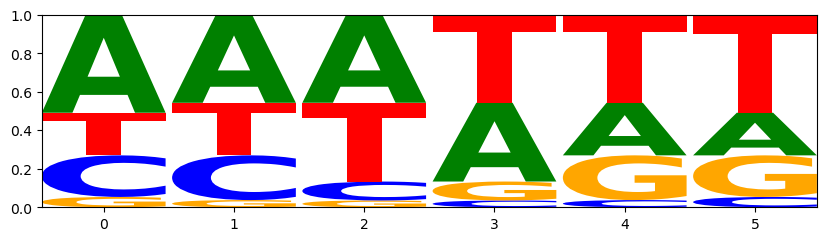

In [46]:
import logomaker

df = pd.DataFrame(PWM, columns=["A","C","G","T"])
logomaker.Logo(df);

In [61]:
bases = "ACGT"
b2i = {b:i for i,b in enumerate(bases)}

k = 6
L = len(train_seqs[0]) 

# position × base matrix
W = np.zeros((L, 4))
counts = np.zeros(L)

In [62]:
for seq in train_seqs:
    seq = seq.upper()
    for i in range(L - k + 1):
        kmer = seq[i:i+k]
        if any(b not in b2i for b in kmer):
            continue
        if kmer not in kmer_weights:
            continue

        w = kmer_weights[kmer]
        if w > 0:
            for j, base in enumerate(kmer):
                W[i + j, b2i[base]] += w
                counts[i + j] += 1

In [63]:
# avoid division by zero
counts[counts == 0] = 1

W /= counts[:, None]

In [64]:
W -= W.mean(axis=1, keepdims=True)

In [65]:
def softmax(x, beta=1.0):
    ex = np.exp(beta * x)
    return ex / ex.sum(axis=1, keepdims=True)

PWM = softmax(W, beta=1.5)

In [66]:
def rc_pwm(P):
    return P[::-1, :][:, [3,2,1,0]]

PWM = 0.5 * (PWM + rc_pwm(PWM))

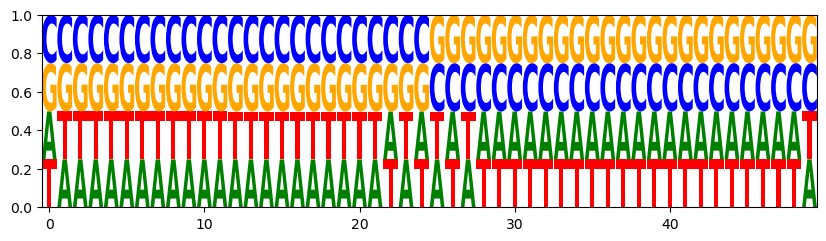

In [68]:
df = pd.DataFrame(PWM, columns=list(bases))
logomaker.Logo(df);

Motif logos are not very informative. Probabilities for all bases at all positions are about equal, and no meaningful pattern emerges -- likely because the model never learned positional information, just kmer frequency in a sequence. So, trying to project the learned kmer weights back to positions does not work well. 